Backgrounds

- Consider adding short-term strategies to long-term strategies to improve returns on long-term strategies
- This could be seen as improving long-term strategy execution strategies and reducing transaction costs.
- When strategies are added together, transactions between strategies cancel each other out, reducing the overall volume of transactions.
- Short-term strategy returns tend to be smaller than costs
- If the reduction in transaction volume is greater when the long-term strategy is added to the short-term strategy, then the short-term strategy can be utilized

Results

- If a small short-term strategy is added to a long-term strategy, the cost of the short-term strategy is negligible
- This implies that any strategy with a positive ideal return will have a return greater than its cost if the weights are adjusted.

In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

Experimentally test the following hypotheses

- If independent positions are combined in the same ratio, the reduction in transaction volumes is 1/sqrt(2)

y_amp 0.1


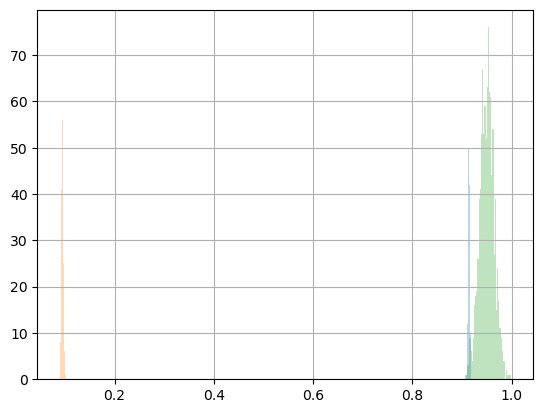

median 0.9137048318828338
mean 0.9136430679646182
r0 median 0.09496567926301479
r0 mean 0.09499286472395871
r1 median 0.9505215503625526
r1 mean 0.9500493087404108
y_amp 0.5


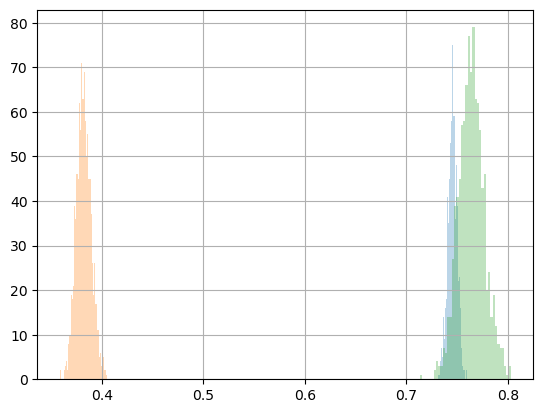

median 0.7453402172074132
mean 0.7452298248322478
r0 median 0.3820016681906107
r0 mean 0.38228816387908965
r1 median 0.7636726159905145
r1 mean 0.763865366606348
y_amp 1.0


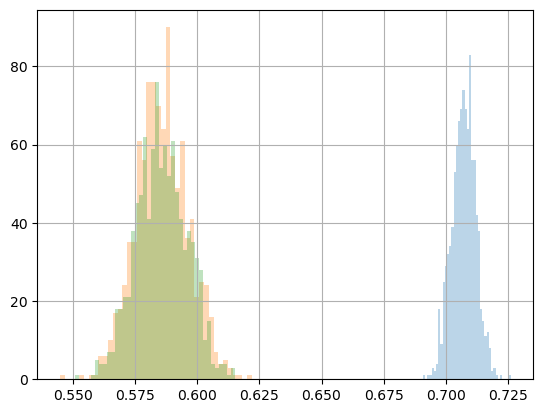

median 0.7071407610517453
mean 0.7071059382792337
r0 median 0.5855891074406736
r0 mean 0.5859279162404061
r1 median 0.5852884176904312
r1 mean 0.5856983878534314


In [2]:
import numpy as np
import pandas as pd

def volume(x):
    return np.mean(np.abs(np.diff(x)))

rs = np.random.RandomState(1)

for y_amp in [0.1, 0.5, 1.0]:
    print('y_amp', y_amp)
    
    m = 1000
    rows = []
    for i in range(m):
        n = 10000
        x = rs.normal(0, 1, n)
        y = rs.normal(0, y_amp, n)
        rows.append({
            'v0': volume(x),
            'v1': volume(y),
            'v_sum': volume(x + y),
        })
    df = pd.DataFrame(rows)
    df['discount'] = df['v0'] + df['v1'] - df['v_sum']
    df['r'] = df['v_sum'] / (df['v0'] + df['v1'])
    df['r0'] = df['discount'] / df['v0']
    df['r1'] = df['discount'] / df['v1']
    df['r'].hist(bins=40, alpha=0.3)
    df['r0'].hist(bins=40, alpha=0.3)
    df['r1'].hist(bins=40, alpha=0.3)
    plt.show()

    print('median', df['r'].median())
    print('mean', df['r'].mean())
    print('r0 median', df['r0'].median())
    print('r0 mean', df['r0'].mean())
    print('r1 median', df['r1'].median())
    print('r1 mean', df['r1'].mean())

Experimentally test the following hypotheses

- If N independent positions are combined in the same ratio, the reduction in transaction volumes is 1/sqrt(N)

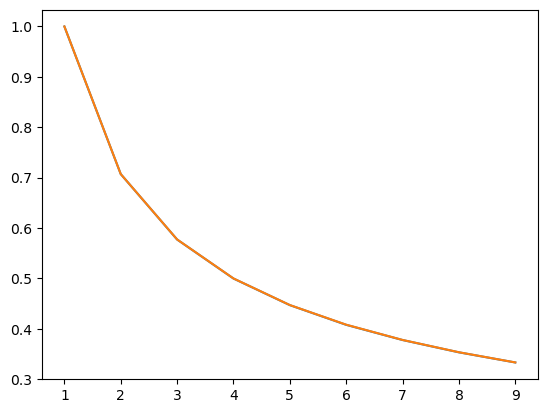

In [3]:
from joblib import Parallel, delayed

def calc_r_mean(N):
    rs = np.random.RandomState(1)
    
    m = 1000
    rows = []
    for i in range(m):
        n = 10000
        v = 0.0
        y = 0.0
        for j in range(N):
            x = rs.normal(0, 1, n)
            v += volume(x)
            y = x + y
        v_sum = volume(y)
        rows.append({
            'v': v,
            'v_sum': v_sum,
        })
    df = pd.DataFrame(rows)
    df['r'] = df['v_sum'] / df['v']
    return df['r'].mean()

Ns = np.arange(1, 10)
rs = Parallel(n_jobs=-1)(delayed(calc_r_mean)(N) for N in Ns)
rs = np.array(rs)

plt.plot(Ns, rs)
plt.plot(Ns, 1.0 / Ns ** 0.5)
plt.show()

Experimentally test the following hypotheses

- Consider a reduction in trading volume as a reduction in the trading volume of a smaller position
- If the smaller positions are small enough, the reduction in volume of the smaller positions is proportional to the amplitude ratio of the positions

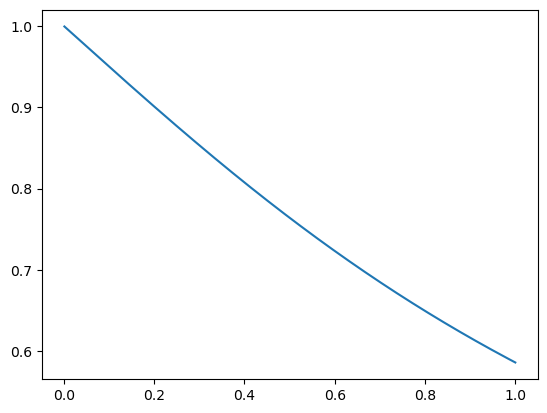

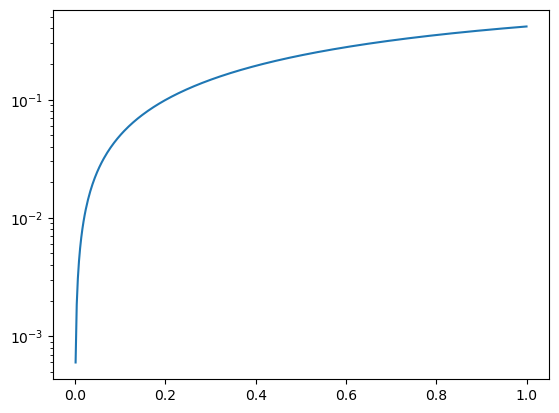

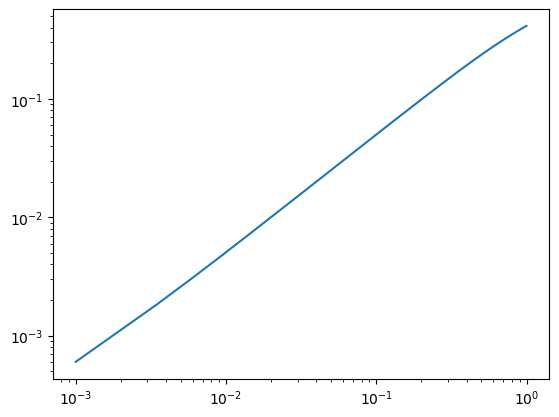

In [4]:
from joblib import Parallel, delayed

def calc_r1_mean(y_amp):
    rs = np.random.RandomState(1)
    
    m = 1000
    rows = []
    for i in range(m):
        n = 10000
        x = rs.normal(0, 1, n)
        y = rs.normal(0, y_amp, n)
        rows.append({
            'v0': volume(x),
            'v1': volume(y),
            'v_sum': volume(x + y),
        })
    df = pd.DataFrame(rows)
    df['discount'] = df['v0'] + df['v1'] - df['v_sum']
    df['r1'] = df['discount'] / df['v1']
    return df['r1'].mean()

y_amps = np.linspace(0.001, 1.0, 400)
r1s = Parallel(n_jobs=-1)(delayed(calc_r1_mean)(y_amp) for y_amp in y_amps)
r1s = np.array(r1s)
    
plt.plot(y_amps, r1s)
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.yscale('log')
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.xscale('log')
plt.yscale('log')
plt.show()

Confirm that the same holds true for cases where there is no frequency coverage in the position.
The exact same thing can't happen, apparently.

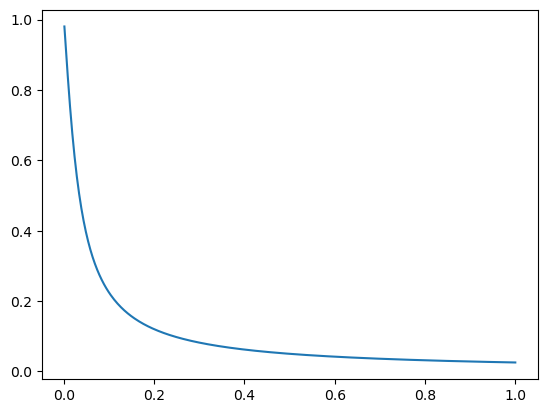

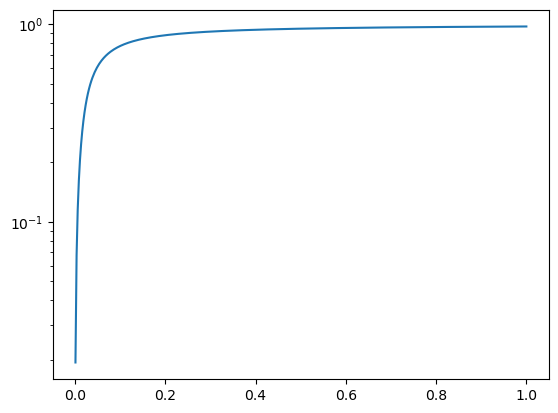

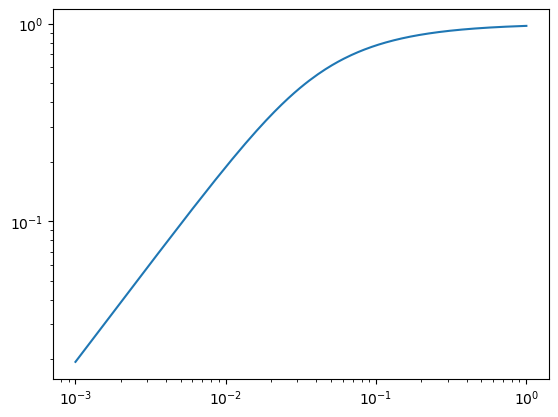

In [5]:
from joblib import Parallel, delayed

def calc_r1_mean(y_amp):
    rs = np.random.RandomState(1)
    
    m = 1000
    rows = []
    for i in range(m):
        n = 10000
        x = rs.normal(0, 1, n)
        y = rs.normal(0, 1, n)
        
        x_fft = np.fft.fft(x)
        y_fft = np.fft.fft(y)
        
        freq = 100
        
        # lowpass
        x_fft[freq + 1:x_fft.shape[0] - freq] = 0.0
            
        # hipass
        y_fft[:freq] = 0.0
        y_fft[y_fft.shape[0] - freq + 1:] = 0.0
        
        x = np.real(np.fft.ifft(x_fft))
        y = np.real(np.fft.ifft(y_fft))
        
        x /= np.std(x)
        y /= np.std(y)
        y *= y_amp
        
        rows.append({
            'v0': volume(x),
            'v1': volume(y),
            'v_sum': volume(x + y),
        })
    df = pd.DataFrame(rows)
    df['discount'] = df['v0'] + df['v1'] - df['v_sum']
    df['r1'] = df['discount'] / df['v1']
    return df['r1'].mean()

y_amps = np.linspace(0.001, 1.0, 400)
r1s = Parallel(n_jobs=-1)(delayed(calc_r1_mean)(y_amp) for y_amp in y_amps)
r1s = np.array(r1s)
    
plt.plot(y_amps, r1s)
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.yscale('log')
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.xscale('log')
plt.yscale('log')
plt.show()

Instead of the amplitude ratio, let's examine the ratio of transaction volume

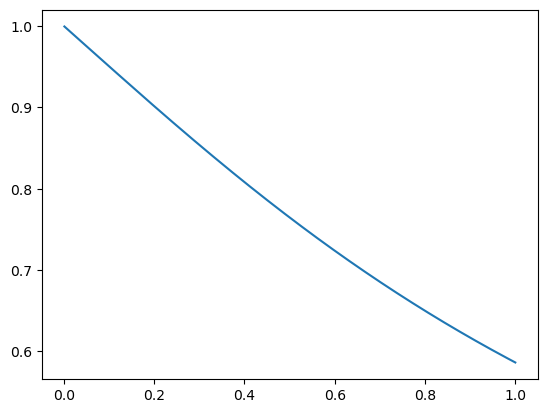

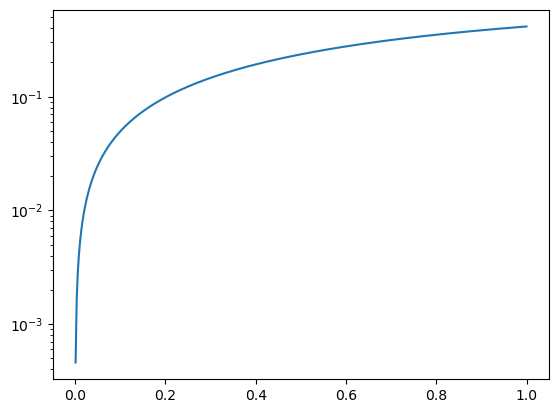

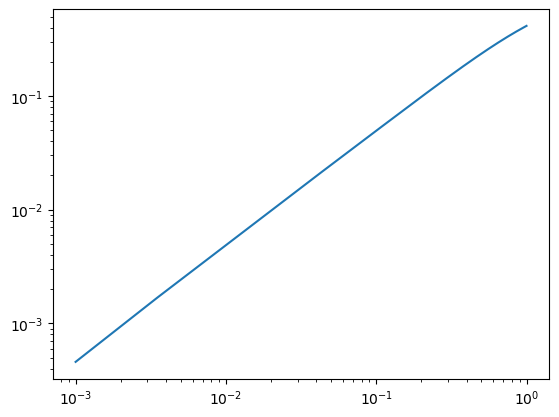

In [6]:
from joblib import Parallel, delayed

def calc_r1_mean(y_amp):
    rs = np.random.RandomState(1)
    
    m = 1000
    rows = []
    for i in range(m):
        n = 10000
        x = rs.normal(0, 1, n)
        y = rs.normal(0, 1, n)
        
        x_fft = np.fft.fft(x)
        y_fft = np.fft.fft(y)
        
        freq = 100
        
        # lowpass
        x_fft[freq + 1:x_fft.shape[0] - freq] = 0.0
            
        # hipass
        y_fft[:freq] = 0.0
        y_fft[y_fft.shape[0] - freq + 1:] = 0.0
        
        x = np.real(np.fft.ifft(x_fft))
        y = np.real(np.fft.ifft(y_fft))
        
        x /= volume(x)
        y /= volume(y)
        y *= y_amp
        
        rows.append({
            'v0': volume(x),
            'v1': volume(y),
            'v_sum': volume(x + y),
        })
    df = pd.DataFrame(rows)
    df['discount'] = df['v0'] + df['v1'] - df['v_sum']
    df['r1'] = df['discount'] / df['v1']
    return df['r1'].mean()

y_amps = np.linspace(0.001, 1.0, 400)
r1s = Parallel(n_jobs=-1)(delayed(calc_r1_mean)(y_amp) for y_amp in y_amps)
r1s = np.array(r1s)
    
plt.plot(y_amps, r1s)
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.yscale('log')
plt.show()
plt.plot(y_amps, 1 - r1s)
plt.xscale('log')
plt.yscale('log')
plt.show()

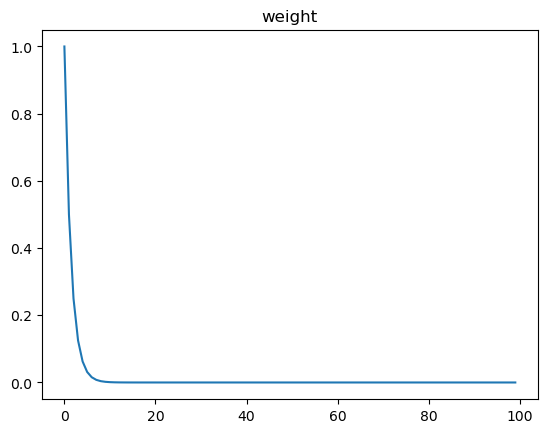

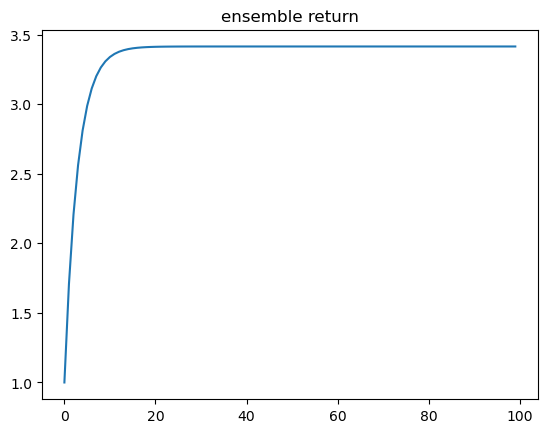

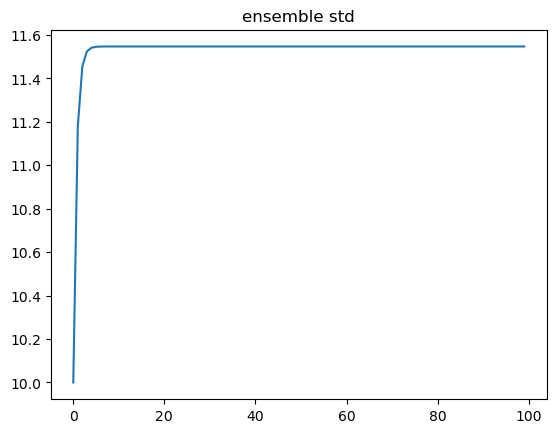

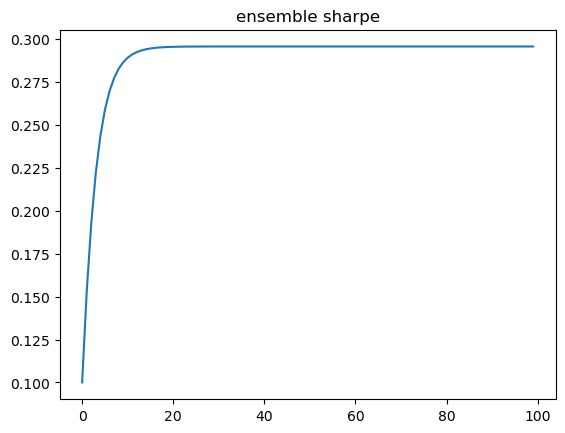

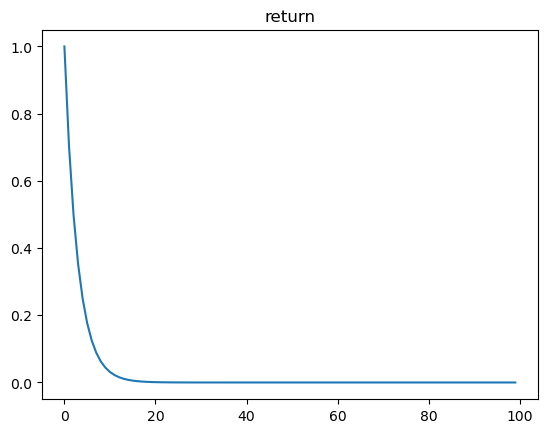

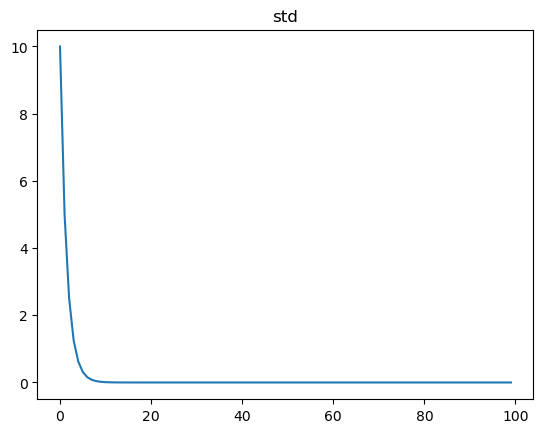

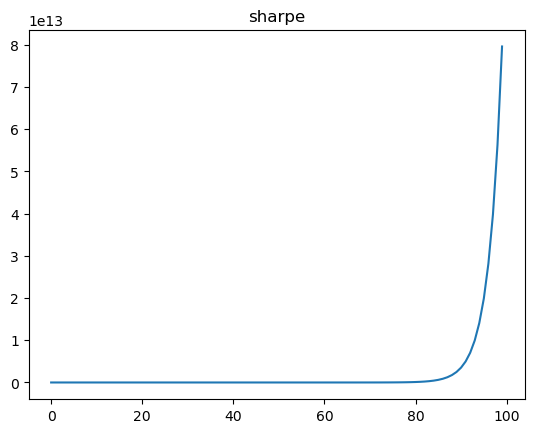

In [34]:
n = np.arange(0, 100)

weight = 0.5 ** n

plt.plot(n, weight)
plt.title('weight')
plt.show()

ret = weight * ((2.0 ** 0.5) ** n)
plt.plot(n, np.cumsum(ret))
plt.title('ensemble return')
plt.show()

base_sharpe = 0.1

vari = (1.0 / base_sharpe ** 2) * (weight ** 2)
plt.plot(n, np.cumsum(vari) ** 0.5)
plt.title('ensemble std')
plt.show()

plt.plot(n, np.cumsum(ret) / (np.cumsum(vari) ** 0.5))
plt.title('ensemble sharpe')
plt.show()

plt.plot(n, ret)
plt.title('return')
plt.show()

plt.plot(n, vari ** 0.5)
plt.title('std')
plt.show()

plt.plot(n, ret / (vari ** 0.5))
plt.title('sharpe')
plt.show()